In [1]:
from Bio import PDB
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import pyfftw
import os
import json
import time

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

%matplotlib inline

# Wrapper

Steps for using the wrapper:

* Load coordinates using Biopython
* Center and rotate the coordinates
* Save them as rcoord.txt, where r is x, y or z
* Create parameters file 
* Run the c++ code
* Load the projected image and the json with the cv and its gradient
* Enjoy

In [2]:
#First let's create some functions

def center_atomic_coord (x,y,z):
    
    x, y, z = x-np.mean(x), y-np.mean(y), z-np.mean(z)
    return(x, y, z) 

def quaternion_rotation(q, x, y, z):
    
    '''
    Performs a rotation using quaternions.
    
    If it is based from a quaternion q1 = w + xi + yj + zk, then the 
    quaternion array q should be q = [x, y, z, w]
    '''
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)
    

def read_grads():
    # Retrieve gradients of each training step fron the text output files
    # from the c++ program

    with open("../data/output/grad.json") as j_file:
        data = json.load(j_file)[0]
        s = data["s"]
        x_grad = np.array(data['sgrad_x']) 
        y_grad = np.array(data['sgrad_y'])
        z_grad = np.array(data['sgrad_z'])

        return s, np.array([x_grad, y_grad, z_grad])
    
def aligment_rotation_matrix(reference, not_reference):
    
    '''
    Returns the rotation matrix that minimizes the rmsd between two molecules
    
    It uses only the CA atoms
    '''
    
    ref = mda.Universe(reference)
    mobile = mda.Universe(not_reference)
    mobile0 = mobile.select_atoms('name CA').positions - mobile.atoms.center_of_mass()
    ref0 = ref.select_atoms('name CA').positions - ref.atoms.center_of_mass()
    Ra, rmsd = align.rotation_matrix(mobile0, ref0)
    return (Ra)

def get_coordinates(name, route_name_pdb):
    
    '''
    Extracts all the x y z coordinates from the pdb, each on on an independent array
    '''
    
    parser = PDB.PDBParser()
    io = PDB.PDBIO()
    struct=parser.get_structure(name,route_name_pdb)
    x_atom=[]
    y_atom=[]
    z_atom=[]
    r_atom=[]
    
    for chains in struct:
        for chain in chains:
            for residue in chain:                             
                for atom in residue:
                    
                    x_atom.append(atom.get_vector()[0])
                    y_atom.append(atom.get_vector()[1])
                    z_atom.append(atom.get_vector()[2])
                    
    x_atom=np.array(x_atom)
    y_atom=np.array(y_atom)
    z_atom=np.array(z_atom)
        
    return(x_atom, y_atom, z_atom)

1. Alinear con MDAnalaysis
2. Hacer el resto, pero con lo que da MDAnalaysis

In [3]:
%%capture
#Load data using MDAnalysis

reference='../data/input/groel_frame_13120.pdb'
not_reference='../data/input/groel_apo.pdb'

#Importat 1xck's PDB to extract XYZ atomic coordinates
groel_frame_13120_universe = mda.Universe(reference)
groel_apo_universe = mda.Universe(not_reference)

In [4]:
#calculate the rotation matrix
Ra = aligment_rotation_matrix(reference, not_reference)

#extract the positions
r_ga = groel_apo_universe.select_atoms('all').positions

#Define the origin as the center of mass
center_of_mass_ga = groel_apo_universe.atoms.center_of_mass()
r_ga_centered = r_ga-center_of_mass_ga

#Rotate the coordinates
r_ga_rotated = np.dot(Ra,r_ga_centered.T)

#save them separetely for the c++ code
x_ga = r_ga_rotated[0]
y_ga = r_ga_rotated[1]
z_ga = r_ga_rotated[2]

In [5]:
#Quaternion parameters
'''
If it is based from a quaternion q1 = w + xi + yj + zk, then the 
quaternion array q should be q = [x, y, z, w]
'''

q=[0, 1/np.sqrt(2), 1/np.sqrt(2), 0]

#Rotate them with quaternions
x_atom_ga, y_atom_ga, z_atom_ga = quaternion_rotation(q, x_ga, y_ga, z_ga)

#Save the coordinates
np.savetxt("../data/input/xcoord.txt", x_atom_ga)
np.savetxt("../data/input/ycoord.txt", y_atom_ga)
np.savetxt("../data/input/zcoord.txt", z_atom_ga)



In [6]:
#Create the parameters file

n = 3; sigma = 1; res = 128

fout = open("../data/input/parameters.txt","w")
fout.write("""NUMBER_PIXELS 124
PIXEL_SIZE 1.77

CTF_B_ENV 1.0
CTF_DEFOCUS 1.0
CTF_AMPLITUDE 0.1

SIGMA 1
SIGMA_REACH 3
""".format(n=n, s=sigma, r=res))
fout.close()

In [7]:
#run the c++ code

#uncomment if it is not compiled yet

#For linux or mac
os.system("cd .. && make");

#For Arley... you need to install fftw3
#os.system('cd .. && g++ -o gradcv.exe src/main2.cpp src/gradcv.cpp -std=c++14 -O3 -Iinclude -lm -lfftw3f')


start = time.time()
os.system("cd .. && ./gradcv.out");

#For Arley... 
os.system("cd .. && .\gradcv.exe")
print("Projection time: {}".format(time.time() - start))

#archivos creados

#Inoctf.txt -> imagen proyectada sin ctf ni ruido gaussiano
#Ictf_noise.txt -> imagen proyectada con ctf y ruido gaussiano
#grad.json -> un json con la cv y el grad

Projection time: 0.11992526054382324


In [8]:
#Load the projected image
Ixy_clean = np.loadtxt("../data/output/Inoctf.txt")
Ixy_noise = np.loadtxt("../data/output/Ictf_noise.txt")

#Load the json with the cv and its gradient
#s, sgrad = read_grads()

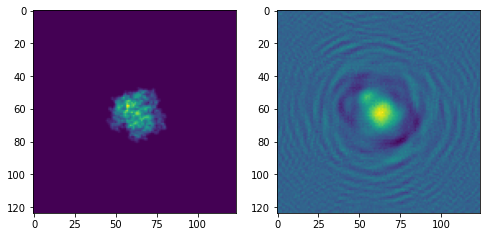

In [9]:
#Checking that everything worked
fig, ax = plt.subplots(1, 2, figsize=(8,5))

im1 = ax[0].imshow(Ixy_clean)#, extent=[x[0],x[-1],y[0],y[-1]], cmap="viridis")
im2 = ax[1].imshow(Ixy_noise)#, extent=[x[0],x[-1],y[0],y[-1]], cmap="viridis")